### Treść zadania

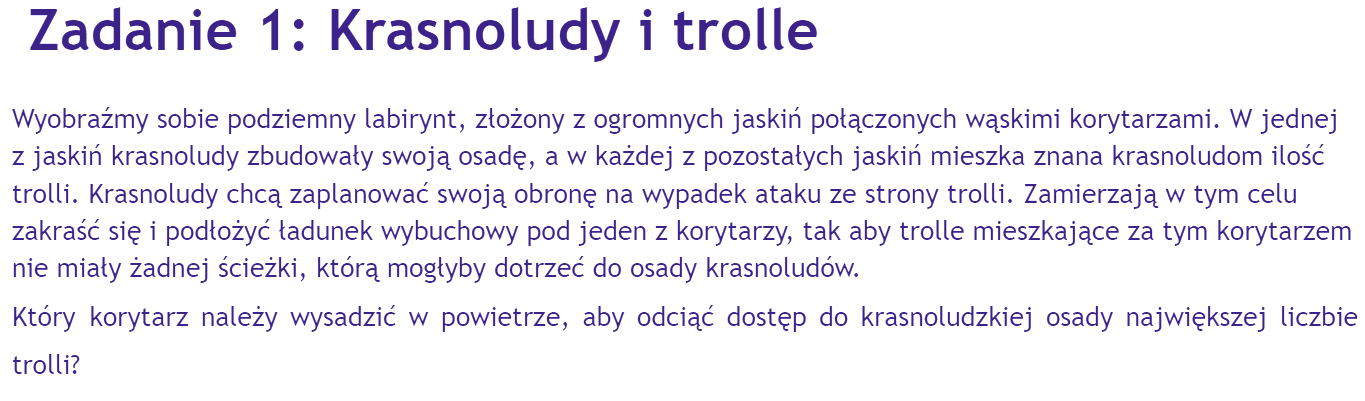

### Omówienie algorytmu

###### I część - szukanie mostów:
W pierwszej kolejności tworzymy oczywiście graf, z krawędzi które otrzymaliśmy na wejściu. Graf będzie reprezentowany w postaci list sądziedztwa, ponieważ pozwala to nam zaoszczędzić pamięć i otrzymamy lepszą złożoność obliczeniową w większości przypadków (jeżeli w grafie są mosty, to graf ma zazwyczaj mało krawędzi). W kolejnym kroku używamy algorytmu, który znajduje mosty, z wykładu (bez zapisywania znalezionych mostów, jedynie wyliczamy wartości $ times $ - czasy odwiedzenia oraz $ low $ - wartości funkcji low, a mosty będzie można na bieżąco odtworzyć, sprawdzając zawsze warunek istnienia mostu). Tym zajmuje się pierwsza funkcja, wykorzystująca algorytm DFS. Po zdobyciu już odpowiednich danych o mostach, przechodzimy do sprawdzenia, który most najlepiej wysadzić.
###### II część - wybieranie najbardziej opłacalnego mostu:
W tym kroku wystarczy przejść jeszcze raz przez graf (dowolnym algorytmem: DFS lub BFS, ale DFS jest łatwiejszy w implementacji). Teraz, szukamy takich mostów, które są jak najwcześniej na danej ścieżce, którą idziemy (tzn. lekceważymy istnienie wszystkich mostów w tych częściach grafu, do których nie dotrzemy już, jeżeli wysadzimy jakiś wcześniejszy most) - patrz niżej:
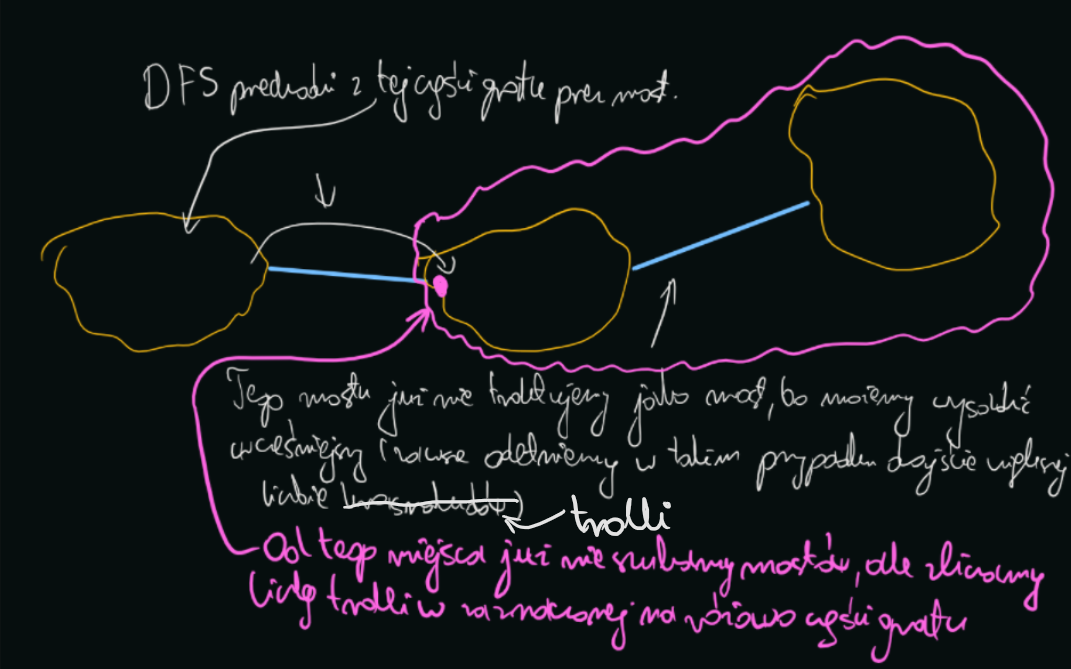
Można powiedzieć, że jest to podejście zachłanne, ponieważ zawsze bierzemy pierwszy most, do którego dojdziemy i już nigdy nie sprawdzamy mostów, które się za nim znajdują. Jest to całkowicie poprawne podejście, ponieważ, skoro dana krawędź jest mostem, nie istnieje inna możliwość dostania się do pozostałej części grafu, a im wcześniej odetniemy fragment grafu, tym więcej wierzchołków odpadnie. Oczywiście nie sprawdzamy tylko jednego mostu, ale idziemy algorytmem DFS do wszystkich wierzchołków w grafie (kolejność nie ma znaczenia) w taki sposób, by nie przechodzić przez most. W momencie, w którym napotkamy na most, rozpoczyna się trzeci etap.
###### III Etap - zliczanie trolli
(Ten etap tak naprawdę następuje w trakcie wykonywania etapu drugiego i może nastąpić wielokrotnie.) <br>
Polega on na tym, że po przejściu przez most (zgodnie z wyżej opisanymi regułami), odpalamy inną funkcję, korzystającą z algorytmu DFS (może być BFS - bez znaczenia) i teraz już po prostu przechodzimy przez całą część grafu, znajdującą się za znalezionym mostem. Nie musimy robić nic szczególnego, bo korzystamy ze wspólnej tablicy, w której zapisujemy odwiedzone wierzchołki, więc mamy pewność, że nigdy nie cofniemy się do części grafu, której nie należy odcinać (tzn. po przejściu raz przez most, się nie wracamy, a z danej części grafu, oddzielonej mostem od pozostałej, nie ma innego wyjścia). Po zliczeniu liczby trolli (włącznie z liczbą trolli w wierzchołku, który znajduje się tuż za mostem), sprawdzamy, czy jest ona większa od poprzedniej. Jeżeli tak, to aktualizujemy tę wartość i zapisujemy nowy most. W ten sposób mamy pewność, że oba algorytmy DFS, działające na zmianę, odwiedzą cały graf tylko raz. (ilustracja, która to obrazuje)
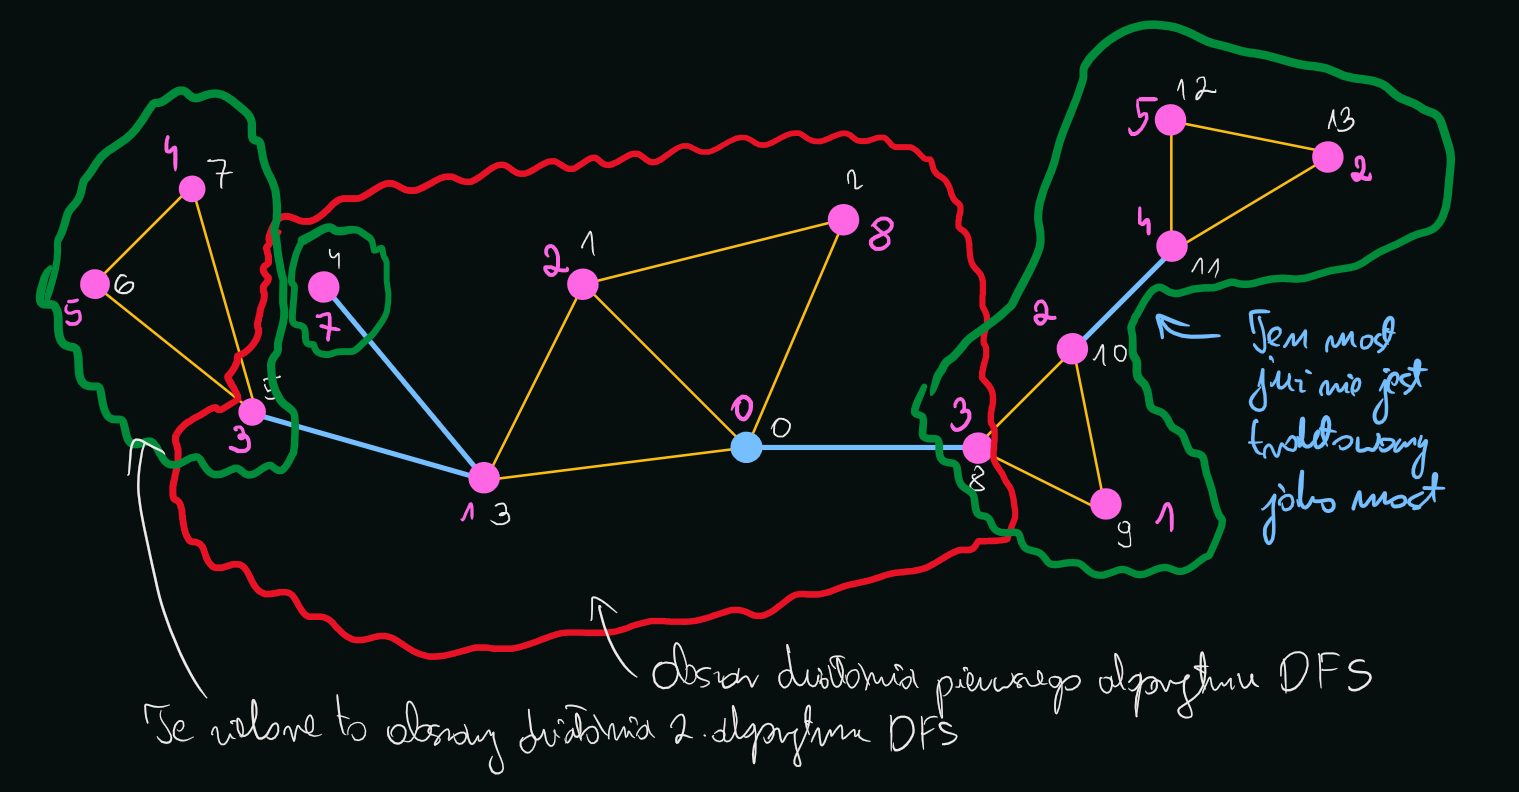

<br><br>
Jeszcze jedna drobna uwaga. Jeżeli w grafie nie ma mostów, zakładamy, że bez sensu jest wysadzanie jakiegokolwiek mostu, ponieważ i tak wszystkie trolle mogą do nas dotrzeć (Tu na myśl przychodzi mi wariant zadania z ważonymi krawędziami - długościami tuneli. Wtedy zawsze warto by było wysadzić jakiś most, który najbardziej by zwiększał pokonany dystans przez największą liczbę trolli, ale to zadanie byłoby już sporo trudniejsze).

### Złożoność

Identyczna do algorytmu DFS dla listowej reprezentacji grafu.
###### Obliczeniowa:
$ O(V + E) $, gdzie $ V $ - liczba wierzchołków, $ E $ - liczba krawędzi,
###### Pamięciowa:
$ O(V) $, gdzie $ V $ - liczba wierzchołków (zakładam, że graf otrzymujemy na wejściu i nie wliczam go do złożoności),

### Implementacja

In [1]:
def undirected_graph_list(E: 'array of edges', n: 'number of vertices'):
    G = [[] for _ in range(n)]
    for edge in E:
        G[edge[0]].append(edge[1])
        G[edge[1]].append(edge[0])
    return G


def bridges(G: 'graph represented by adjacency lists'):
    n = len(G)
    low = [0] * n
    times = [0] * n
    time = 0
    
    def dfs(u, parent):
        nonlocal time
        time += 1
        low[u] = times[u] = time
                
        for v in G[u]:
            # when there is no visit time, a vertex hasn't been yet visited
            if not times[v]:
                dfs(v, u)
                # If we have a cycle, we must update the low value of the parent vertex
                if low[v] < low[u]: low[u] = low[v]
            # v cannot be a parent of u as it's obvious it will always be visited before
            # and connected to the vertex u which doesn't imply that we have a trailing edge
            elif v != parent:  
                # We have a back edge (we try to enter a vertex which was entered before)
                if times[v] < low[u]: low[u] = times[v]
    
    # I assume that dwarfs' cave is in the 0 vertex
    dfs(0, -1)
            
    return times, low


def blow_up_bridge(G: 'graph represented by adjacency lists', C: 'counts of trolls in caves'):
    # We will check if there is a bridge for each vertex
    times, low = bridges(G)
    n = len(G)
    visited = [False] * n
    best_count = 0
    best_bridge = None
    
    # Define the first DFS function which will look for the closest bridges
    def dfs_bridge(u):
        visited[u] = True
        # Check each neighbour if there is a bridge or not (if it hasn't been yet visited)
        for v in G[u]:
            # A visited array guarantees that we will always start from the closest bridge
            # if there are some later (the first bridge on a particular path)
            if not visited[v]:
                # Check if there is a bridge. If it does so, start another DFS algorithm
                if low[v] == times[v]:  # There is a bridge between (from u to v)
                    nonlocal best_bridge, best_count
                    # Start a DFS (can be BFS, it doesn't matter now) in the subgraph
                    # on the other side of a bridge (from a vertex v)
                    # (We are sure this algorithm will visit only such vertices which are
                    # in a part of a graph which will become disconnected after blowing up
                    # the u-v bridge as there is only one way to get back to the grap - via
                    # this bridge which has already been visited)
                    curr_count = dfs_count(v)
                    if curr_count > best_count:
                        best_count = curr_count
                        best_bridge = (u, v)
                # If there is no bridge, just continue searching for a bridge (or another bridge
                # which will result in disconnectiong more trolls)
                else:
                    dfs_bridge(v)
                
    # A DFS function which counts a number of trolls
    def dfs_count(u):
        visited[u] = True
        total = C[u]
        for v in G[u]:
            if not visited[v]:
                total += dfs_count(v)
        return total
                
    # Start looking for the closest bridges from dwarfs' cave
    dfs_bridge(0)
    
    # Return the result
    return best_bridge, best_count

###### Kilka testów

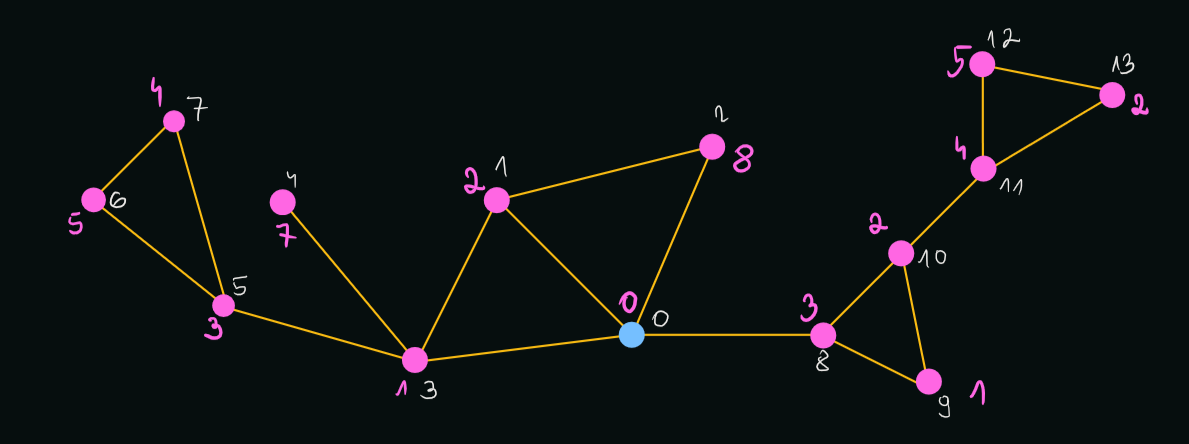

In [2]:
E = [(0, 1), (1, 2), (2, 0), (3, 1), (3, 0), (4, 3), (5, 3), (5, 7), (5, 6), (6, 7), (0, 8), (8, 9),
     (9, 10), (8, 10), (10, 11), (11, 12), (12, 13), (11, 13)]
C = [0, 2, 8, 1, 7, 3, 5, 4, 3, 1, 2, 4, 5, 2]

G = undirected_graph_list(E, len(set(u for edge in E for u in edge)))
print(blow_up_bridge(G, C))

((0, 8), 17)


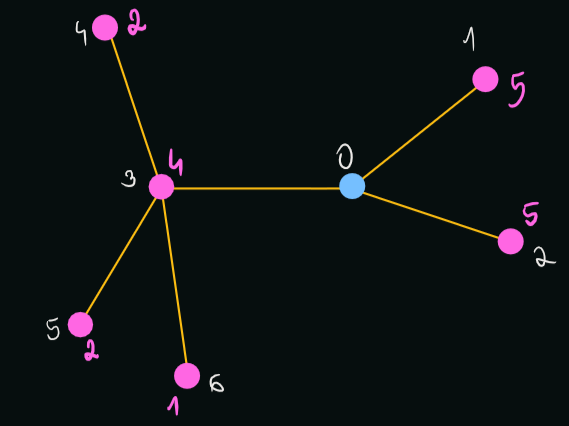

In [3]:
E = [(0, 1), (0, 2), (0, 3), (3, 4), (3, 5), (3, 6)]
C = [0, 5, 5, 4, 2, 2, 1]

G = undirected_graph_list(E, len(set(u for edge in E for u in edge)))
print(blow_up_bridge(G, C))

((0, 3), 9)


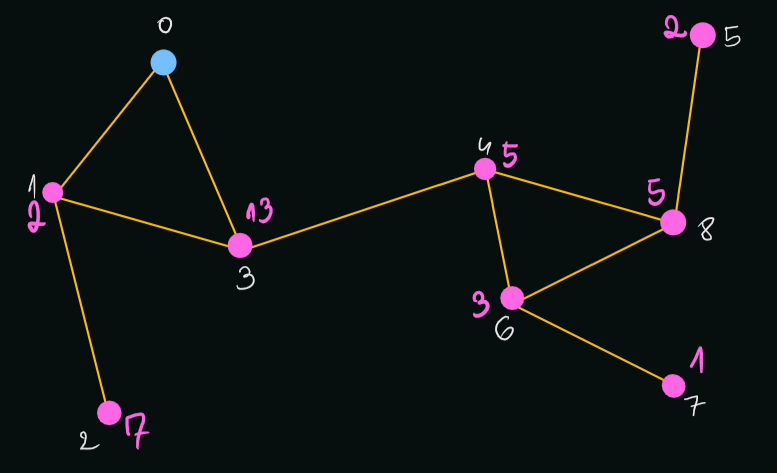

In [4]:
E = [(0, 1), (1, 2), (1, 3), (3, 0), (3, 4), (4, 8), (8, 5), (4, 6), (6, 8), (7, 6)]
C = [0, 2, 7, 13, 5, 2, 3, 1, 5]

G = undirected_graph_list(E, len(set(u for edge in E for u in edge)))
print(blow_up_bridge(G, C))

((3, 4), 16)


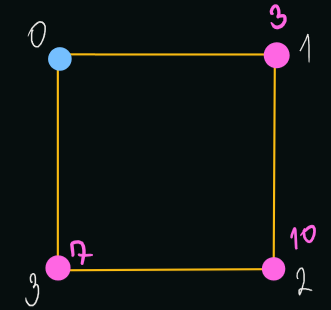

In [5]:
E = [(0, 1), (1, 2), (3, 0), (3, 2)]  # Brak mostów w tym grafie, więc nie opłaca się nic wysadzać
C = [0, 3, 10, 7]

G = undirected_graph_list(E, len(set(u for edge in E for u in edge)))
print(blow_up_bridge(G, C))

(None, 0)
